# Cart Pole
[link to gymnasium doc](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

Action space:
- 0 (move cart to left)
- 1 (move cart to right)

Observation space:
- cart position (between -4.8 and 4.8)
- cart velocity (between -inf and inf)
- pole angle in radians (between -0.418 and 0.418 rad)
- pole angular velocity (between -inf and inf)

Reward: 1 for every step taken

starting state & termination:
- ALL observations are assigned a uniformly random value in (-0.05, 0.05)
- the episode terminates if the cart leaves the (-2.4, 2.4) range
- the episode terminates if the pole angle is not in the range (-.2095, .2095) (or ±12°)
- episode terminates if its length is greater than 500

In [124]:
import cv2
import gymnasium as gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import imageio
import numpy as np

import random
from collections import namedtuple, defaultdict

# monte carlo samples episodes then learns Q table using simple monte carlo estimates.
def monte_carlo(n_episodes=100):
    env = gym.make('CartPole-v1', render_mode="rgb_array")
    n_actions = env.action_space.n
    bin_size = 30
    bins = get_bins(bin_size=bin_size)
    
    # Q lookup table: q(state, action).
    Q = np.random.uniform(size=[bin_size]*len(bins) + [n_actions])
    # returns table: returns(state, action)
    R = np.zeros_like(Q)
    # Counters table: number of times state, action pair was visited for the first time
    N = np.zeros_like(Q) 

    # rewards record used to monitor learning progress.
    rewards = []
    for i in tqdm(range(n_episodes)):
        policy_wrapper = lambda obs: policy(epsilon=1/i+1, Q=Q, bins=bins, observation=obs)
        episode = sample_episode(policy_wrapper, env, render=False)
        rewards.append(sum(e.reward for e in episode))
        # visited table keeps track of visited state, action pairs. visited[state, action] = bool
        visited = defaultdict(bool)
        r = 0
        for e in episode[::-1]:  # returns are summed from T to 1.
            p, pv, a, av = digitize(e.observation, bins)

            state = (p, pv, a, av, e.action)
            r += e.reward
            if visited[state]:
                continue

            visited[state] = True
            R[p, pv, a, av, e.action] += r
            N[p, pv, a, av, e.action] += 1
            Q[p, pv, a, av, e.action] = R[p, pv, a, av, e.action]/N[p, pv, a, av, e.action]
        
    env.close()
    return Q, rewards

# Record namedtuple contains action, observation, reward and frame for a single time step.
# An episode is a collection of records.
Record = namedtuple("Record", "action observation reward frame")

# sample_episode samples an episode using the policy. Doesn't do any update during the episode.
# render (bool) determines whether to render frames.
def sample_episode(policy, env, render=False):
    episode = []
    terminated = False
    truncated = False
    step = 0
    obs, info = env.reset()
    while not (terminated or truncated):
        step += 1
        frame = None
        if render:
            frame = env.render()
            cv2.putText(
                img=frame, 
                text=f'steps={step}/500', 
                org=(10, 50), 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=1, 
                color=(0, 0, 255), 
                thickness=2, 
                lineType=cv2.LINE_AA
            )
        action = policy(obs)
        new_obs, reward, terminated, truncated, info = env.step(action)
        episode.append(
            Record(
                action=action, 
                observation=obs, 
                reward=reward,
                frame=frame,
            ),
        )
        obs = new_obs
    return episode

# policy is epsilon-greedy with respect to Q.
def policy(epsilon, Q, bins, observation):
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, Q.shape[-1] - 1)  # right bound is included
    
    p, pv, a, av = digitize(observation, bins)
    return np.argmax(Q[p, pv, a, av, :])

# get_bins returns bins used to quantize the observations.
def get_bins(bin_size=30):
    bins = [
        np.linspace(-4.8,4.8,bin_size),
        np.linspace(-4,4,bin_size),
        np.linspace(-0.418,0.418,bin_size),
        np.linspace(-4,4,bin_size)
    ]
    return bins

# digitize quantizes the observations into bins. Returns bin indexes (0-based).
def digitize(obs, bins):
    res = []
    for o, b in zip(obs, bins):
        res.append(
            np.digitize(o, b) - 1
        )
    return res


  0%|          | 0/50000 [00:00<?, ?it/s]

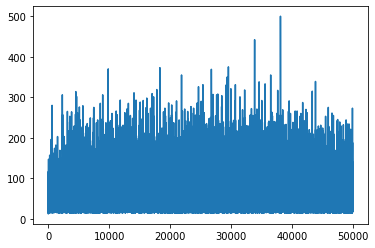

In [55]:
import matplotlib.pyplot as plt
Q, r = monte_carlo(n_episodes=50000)
plt.plot(np.arange(len(r)), r)

  0%|          | 0/16000 [00:00<?, ?it/s]

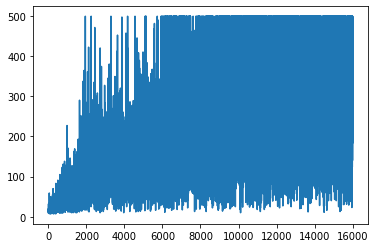

In [118]:
# Q-learning
env = gym.make('CartPole-v1', render_mode="rgb_array")

# initialize Q table
n_actions = env.action_space.n
bin_size = 30
bins = get_bins(bin_size=bin_size)
Q = np.random.uniform(size=[bin_size]*len(bins) + [n_actions]) 
# Q: no need to set terminal states to 0?

n_episodes = 16000
# returns keeps track of returns for each episode to monitor learning progress.
returns = []
# t used to set learning rate alpha = 1/t
t = 1
gamma = 0.995
for i in tqdm(range(n_episodes)):
    # epsilon = 1/(i+1)?
    policy_fn = lambda obs: policy(epsilon=0.2, Q=Q, bins=bins, observation=obs)

    obs, info = env.reset()

    terminated = False
    truncated = False
    curr_returns = 0
    while not (terminated or truncated):
        alpha = 0.1
        action = policy_fn(obs)
        new_obs, reward, terminated, truncated, info = env.step(action)
        if not (terminated or truncated):
            p, pv, a, av = digitize(obs, bins)
            pn, pvn, an, avn = digitize(new_obs, bins)
            q1 = Q[p, pv, a, av, action]
            q2 = Q[pn, pvn, an, avn, :].max()
            #new_action = policy_fn(new_obs)
            #q2 = Q[pn, pvn, an, avn, new_action]
            Q[p, pv, a, av, action] = q1 * (1 - alpha) + alpha * (reward + gamma * q2) 
            curr_returns += reward
            t += 1
        obs = new_obs
    returns.append(curr_returns)

env.close() 

plt.plot(np.arange(len(returns)), returns)
    

In [125]:
# run episode and save to gif
env = gym.make('CartPole-v1', render_mode="rgb_array")
bins = get_bins()
policy_wrapper = lambda obs: policy(epsilon=0., Q=Q, bins=bins, observation=obs)
episode = sample_episode(policy_wrapper, 1, env, render=True)
frames = [e.frame for e in episode]
fps = 30
imageio.mimsave('cartpole.gif', frames, duration=len(episode)/fps)
env.close()